In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer  # Imported make_scorer
)

# Set random seed for reproducibility
np.random.seed(32)

# Read the CSV file
file_path = 'training.csv' 
df = pd.read_csv(file_path)

# Split the data into training and testing sets (80%-20%)
X = df.drop(columns=['increase_stock'])  # Features
y = df['increase_stock']  # Target

# Split the data into training and testing sets
X = df.drop(columns=['increase_stock'])  # Features
y = df['increase_stock']  # Target

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32, stratify=y
)

# Preprocessing: Cyclic encoding for 'hour_of_day', 'day_of_week', and 'month'
for df_split in [X_train, X_test]:
    df_split.loc[:, 'hour_sin'] = np.sin(2 * np.pi * df_split['hour_of_day'] / 24)
    df_split.loc[:, 'hour_cos'] = np.cos(2 * np.pi * df_split['hour_of_day'] / 24)
    df_split.loc[:, 'day_sin'] = np.sin(2 * np.pi * df_split['day_of_week'] / 7)
    df_split.loc[:, 'day_cos'] = np.cos(2 * np.pi * df_split['day_of_week'] / 7)
    df_split.loc[:, 'month_sin'] = np.sin(2 * np.pi * df_split['month'] / 12)
    df_split.loc[:, 'month_cos'] = np.cos(2 * np.pi * df_split['month'] / 12)

# Selecting final features (exclude original cyclic columns)
final_features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
    'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'visibility'
]

X_train = X_train[final_features]
X_test = X_test[final_features]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [2]:
## LDA
print("LDA:")
print("===\n")

# Initialize LDA
lda = LinearDiscriminantAnalysis()

# LDA - train the LDA model on the training data
lda.fit(X_train, y_train)

# LDA - predict on the test data
y_pred = lda.predict(X_test)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(lda, X_train_scaled, y_train, cv=5, scoring='f1_macro')  # Replace 'accuracy' with your metric of choice

# Results
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

# LDA - evaluate the LDA model
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

LDA:
===

Cross-validation scores: [0.75786423 0.73398489 0.69670754 0.74844415 0.73902741]
Mean accuracy: 0.7352056438805358
Standard deviation: 0.02091348839104723

Accuracy: 0.859375

Classification Report:
                   precision    recall  f1-score   support

high_bike_demand       0.61      0.64      0.62        58
 low_bike_demand       0.92      0.91      0.91       262

        accuracy                           0.86       320
       macro avg       0.76      0.77      0.77       320
    weighted avg       0.86      0.86      0.86       320



In [3]:
## LDA with grid search
print("LDA with grid search:")
print("=====================\n")

# Initialize LDA
lda = LinearDiscriminantAnalysis()

# Grid search
param_grid = [ # Define the parameter grid
    {'solver': ['svd'], 'shrinkage': [None]},  # No shrinkage for 'svd'
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]}, 
]
grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
# Best parameters: {'n_components': None, 'shrinkage': 0.1, 'solver': 'lsqr'}
# Best cross-validation score: 0.8671875

best_lda = grid_search.best_estimator_
y_pred = best_lda.predict(X_test_scaled)
## y_pred_prob = best_lda.predict_proba(X_test_scaled)[:, 1]

# Perform 5-fold cross-validation
cv_scores = cross_val_score(lda, X_train_scaled, y_train, cv=5, scoring='f1_macro')  # Replace 'accuracy' with your metric of choice

# Results
print("\nCross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

# LDA - evaluate the LDA model
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

LDA with grid search:

Best parameters: {'shrinkage': 0.1, 'solver': 'lsqr'}
Best cross-validation score: 0.8671875

Cross-validation scores: [0.75786423 0.73398489 0.69670754 0.74844415 0.73902741]
Mean accuracy: 0.7352056438805358
Standard deviation: 0.02091348839104723

Test Accuracy: 0.871875
Classification Report:
                   precision    recall  f1-score   support

high_bike_demand       0.64      0.67      0.66        58
 low_bike_demand       0.93      0.92      0.92       262

        accuracy                           0.87       320
       macro avg       0.78      0.79      0.79       320
    weighted avg       0.87      0.87      0.87       320



In [4]:
## QDA
print("QDA:")
print("===\n")

# Initialize QDA
qda = QuadraticDiscriminantAnalysis()

# QDA - train the LDA model on the training data
qda.fit(X_train, y_train)

# QDA - predict on the test data
y_pred = qda.predict(X_test)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(qda, X_train_scaled, y_train, cv=5, scoring='f1_macro')  # Replace 'accuracy' with your metric of choice

# Results
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

# QDA - evaluate the QDA model
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

QDA:
===

Cross-validation scores: [0.27683616 0.29411765 0.32338248 0.30362492 0.26803173]
Mean accuracy: 0.29319858523465686
Standard deviation: 0.01960469350851981

Accuracy: 0.75625

Classification Report:
                   precision    recall  f1-score   support

high_bike_demand       0.17      0.09      0.11        58
 low_bike_demand       0.82      0.90      0.86       262

        accuracy                           0.76       320
       macro avg       0.49      0.50      0.49       320
    weighted avg       0.70      0.76      0.72       320



/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are colline

In [5]:
# QDA with Grid Search
print("QDA with Grid Search:")
print("=====================\n")

# Initialize the QDA model
qda = QuadraticDiscriminantAnalysis()

# Define the hyperparameter grid
param_grid = {
    'reg_param': [0.0, 0.1, 0.2, 0.5, 0.9, 1.0],  # Regularization parameter
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for convergence
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(qda, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Display best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train the best QDA model found
best_qda = grid_search.best_estimator_

# Perform 5-fold cross-validation using F1-score (or any other metric)
cv_scores = cross_val_score(best_qda, X_train_scaled, y_train, cv=5, scoring='f1_macro')  
print("\nCross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

# Make predictions on the test set
y_pred = best_qda.predict(X_test_scaled)

# Evaluate the model on the test set
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

QDA with Grid Search:

Best parameters: {'reg_param': 0.9, 'tol': 0.0001}
Best cross-validation score: 0.85859375

Cross-validation F1 scores: [0.79013787 0.79487179 0.73076923 0.80590408 0.73504985]
Mean F1 score: 0.7713465657312839
Standard deviation: 0.031826851830079966

Test Accuracy: 0.859375
Classification Report:
                   precision    recall  f1-score   support

high_bike_demand       0.59      0.71      0.65        58
 low_bike_demand       0.93      0.89      0.91       262

        accuracy                           0.86       320
       macro avg       0.76      0.80      0.78       320
    weighted avg       0.87      0.86      0.86       320



/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are colline

LDA ROC and PR Curves:

QDA ROC and PR Curves:



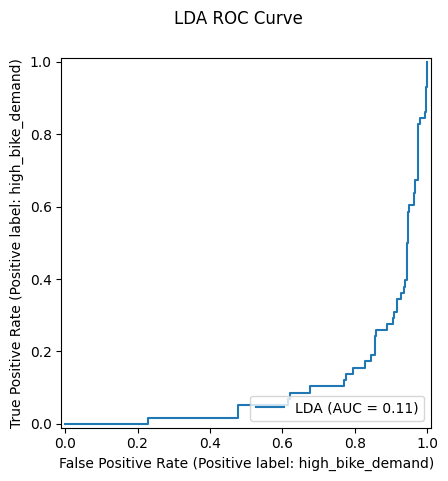

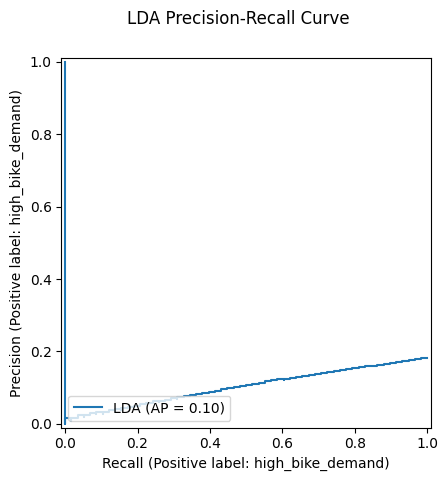

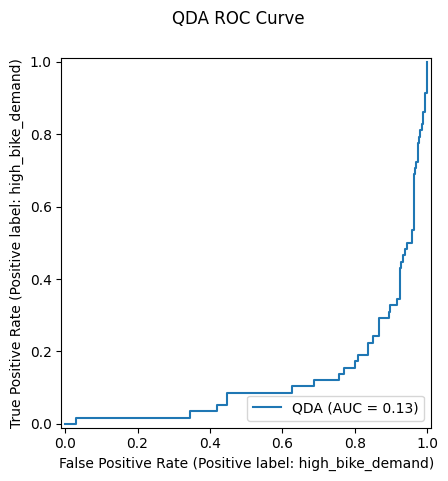

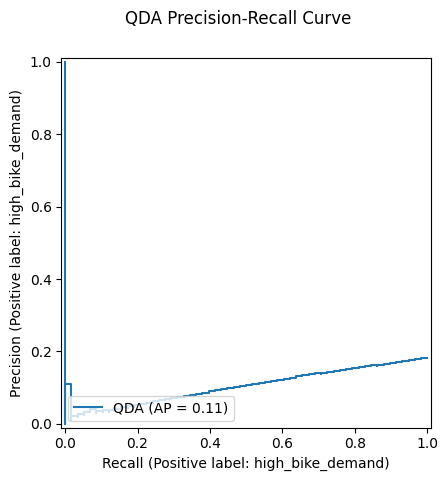

In [6]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# LDA - ROC and PR Curve
print("LDA ROC and PR Curves:")
print("=====================\n")

lda_probs = best_lda.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
roc_disp = RocCurveDisplay.from_predictions(
    y_test,
    lda_probs,
    name="LDA",
    pos_label='high_bike_demand'
)
roc_disp.figure_.suptitle("LDA ROC Curve")

# PR Curve
pr_disp = PrecisionRecallDisplay.from_predictions(
    y_test,
    lda_probs,
    name="LDA",
    pos_label='high_bike_demand'
)
pr_disp.figure_.suptitle("LDA Precision-Recall Curve")

# QDA - ROC and PR Curve
print("QDA ROC and PR Curves:")
print("=====================\n")

qda_probs = best_qda.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
roc_disp = RocCurveDisplay.from_predictions(
    y_test,
    qda_probs,
    name="QDA",
    pos_label='high_bike_demand'
)
roc_disp.figure_.suptitle("QDA ROC Curve")

# PR Curve
pr_disp = PrecisionRecallDisplay.from_predictions(
    y_test,
    qda_probs,
    name="QDA",
    pos_label='high_bike_demand'
)
pr_disp.figure_.suptitle("QDA Precision-Recall Curve")

plt.show()
